# EMG Comparison Analysis

This notebook analyzes electromyography (EMG) data to compare muscle activation patterns between human subjects and the KINESIS simulation model during walking. The analysis focuses on gait cycles and correlation of muscle activation patterns.

Copyright (c) 2025 Mathis Group for Computational Neuroscience and AI, EPFL
All rights reserved.

Licensed under the BSD 3-Clause License.

### Setup and Data Loading

First, we import the necessary libraries and load the simulation data:

In [1]:
import numpy as np
import joblib
import matplotlib.pyplot as plt

We navigate to the parent directory and load the simulation data:

In [ ]:
%cd ..
%pwd

In [3]:
gait = np.load('data/emg_assets/kinesis/gait.npy')
muscle_controls = np.load('data/emg_assets/kinesis/muscle_controls.npy')

### Analyzing Gait Cycles

We first visualize the foot contact patterns during gait:

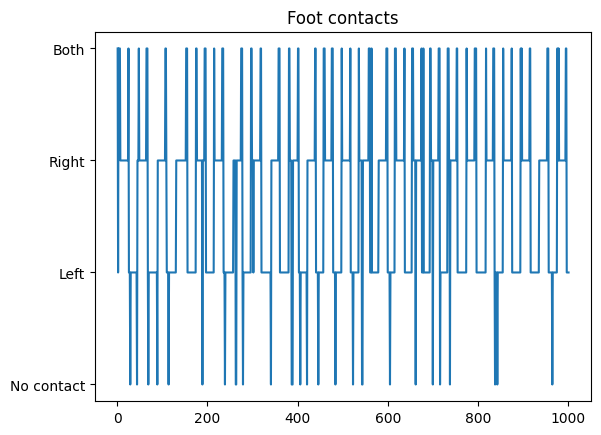

In [4]:
plt.plot(gait)
plt.yticks([-1, 0, 1, 2], ["No contact", "Left", "Right", "Both"])
plt.title("Foot contacts")
plt.show()

This plot shows the foot contact sequence during walking, with the y-axis indicating whether there's no contact, left foot contact, right foot contact, or both feet in contact with the ground. In the following cell, we extract the time points where the left and right alternate.

In [5]:
def find_gait_cycle(gait):
    length = gait.shape[0]
    gait_cycle = []
    flag = 1
    for i in range(length):
        if gait[i] == 0 and flag == 1:
            gait_cycle.append(i)
            flag = 0
        if gait[i] == 1 and flag == 0:
            gait_cycle.append(i)
            flag = 1
    return gait_cycle

gait_cycle = find_gait_cycle(gait)

We then visualize these identified points on the gait data:

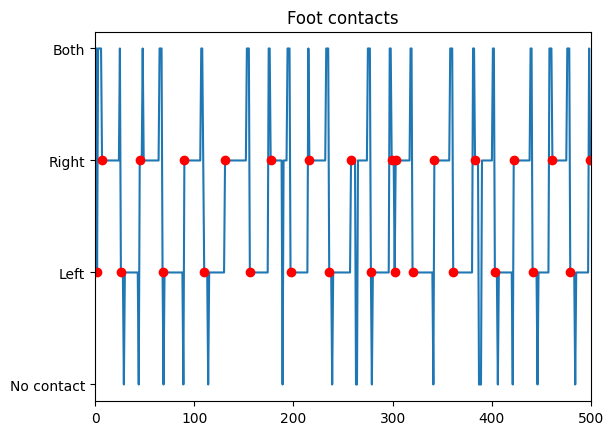

In [6]:
plt.plot(gait)
plt.plot(gait_cycle, gait[gait_cycle], 'ro')
plt.yticks([-1, 0, 1, 2], ["No contact", "Left", "Right", "Both"])
plt.title("Foot contacts")
plt.xlim(0, 500)
plt.show()

The red dots represent the transition points. The ones corresponding to the left foot mark the start and end of gait cycles.

### Segmenting and Interpolating Muscle Control Data

Next, we calculate complete gait cycles and prepare to analyze muscle activation patterns:

In [7]:
# Calculate gait cycles as tuples of (start, end). Gait cycles start at 0 and end at 2, 4, 6, etc.
gait_indexes = []
for i in range(2, len(gait_cycle), 2):
    gait_indexes.append((gait_cycle[i-2], gait_cycle[i]))

gait_lengths = [gait_indexes[i][1] - gait_indexes[i][0] for i in range(len(gait_indexes))]

We create functions to extract and normalize muscle control data for each gait cycle:

In [8]:
from scipy.interpolate import interp1d

def get_muscle_control_cycle(muscle_id):
    muscle_control_cycle = []
    for cycle in gait_indexes:
        muscle_control_cycle.append(muscle_controls[cycle[0]:cycle[1], muscle_id])
    return muscle_control_cycle

def interpolate_muscle_control_cycle(muscle_id):
    """
    Remove sequences that are too short or too long, then interpolate the remaining sequences to 100 samples
    """
    muscle_control_cycle = get_muscle_control_cycle(muscle_id)
    muscle_control_cycle_lengths = [len(muscle_control_cycle[i]) for i in range(len(muscle_control_cycle))]
    muscle_control_cycle_lengths_mean = np.mean(muscle_control_cycle_lengths)
    muscle_control_cycle_lengths_std = np.std(muscle_control_cycle_lengths)

    muscle_control_cycle_f = [muscle_control_cycle[i] for i in range(len(muscle_control_cycle)) if len(muscle_control_cycle[i]) > muscle_control_cycle_lengths_mean - 2*muscle_control_cycle_lengths_std and len(muscle_control_cycle[i]) < muscle_control_cycle_lengths_mean + 2*muscle_control_cycle_lengths_std]

    muscle_control_cycle_f_interp = []
    for i in range(len(muscle_control_cycle_f)):
        f = interp1d(np.linspace(0, 1, len(muscle_control_cycle_f[i])), muscle_control_cycle_f[i])
        muscle_control_cycle_f_interp.append(f(np.linspace(0, 1, 100)))
    return muscle_control_cycle_f_interp

The `interpolate_muscle_control_cycle` function:
1. Extracts muscle activation data for each gait cycle
2. Removes outlier cycles (too short or too long)
3. Interpolates each cycle to a standard length (100 samples) to allow comparison

We then visualize the average muscle activation pattern for a specific muscle (ID 6):

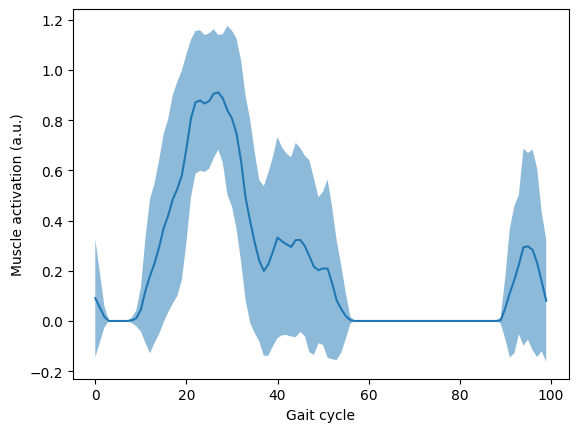

In [9]:
muscle_control_cycle_f_interp = interpolate_muscle_control_cycle(6)
avg_muscle_control_cycle = np.mean(muscle_control_cycle_f_interp, axis=0)
std_muscle_control_cycle = np.std(muscle_control_cycle_f_interp, axis=0)

plt.plot(avg_muscle_control_cycle)
plt.fill_between(np.arange(100), avg_muscle_control_cycle-std_muscle_control_cycle, avg_muscle_control_cycle+std_muscle_control_cycle, alpha=0.5)
plt.ylabel("Muscle activation (a.u.)")
plt.xlabel("Gait cycle")
plt.show()

The plot shows the mean activation profile with standard deviation shading across the gait cycle.

### Processing All Muscles

We load muscle names and create a dictionary containing the average activation pattern for each muscle:

In [10]:
muscle_names = np.load("data/emg_assets/misc/muscle_names.npy")

control_cycle_dict = {}

for i in range(muscle_names.shape[0]):
    muscle_control_cycle_f_interp = interpolate_muscle_control_cycle(i)
    avg_muscle_control_cycle = np.mean(muscle_control_cycle_f_interp, axis=0)
    std_muscle_control_cycle = np.std(muscle_control_cycle_f_interp, axis=0)
    control_cycle_dict[muscle_names[i]] = (avg_muscle_control_cycle, std_muscle_control_cycle)

We create a mapping between human-readable muscle names and their corresponding identifiers in the simulation:

In [11]:
muscle_map = {
    'Soleus': 'soleus_l',
    'Medial Gastrocnemius': 'gasmed_l',
    'Lateral Gastrocnemius': 'gaslat_l',
    'Tibialis Anterior': 'tibant_l',
    'Semimembranosus': 'semimem_l',
    'Biceps Femoris': 'bfsh_l',
    'Vastus Lateral': 'vaslat_l',
    'Rectus Femoris': 'recfem_l',
    'Vastus Medial': 'vasmed_l',
}

### Loading Human EMG Data

We load EMG data from human subjects (subjects 4-12):

In [12]:
# load human EMG data
human_emg = {}
for subject in range(4, 13):
    human_emg[subject] = np.load(f"data/emg_assets/human_emg/EMG_subject_{subject:02d}_walk_45_avg.npy")

### Calculating Correlations

#### Human-to-Human Correlation

We calculate the correlation between EMG patterns from different human subjects. This provides a baseline for how much variability exists between different human subjects for each muscle.

In [13]:
# human-human correlation
hh_correlation = np.zeros((36, 9))

for muscle_id in range(9):
    for idx, (i, j) in enumerate([(i, j) for i in range(4, 12) for j in range(i + 1, 13)]):
        hh_correlation[idx, muscle_id] = np.corrcoef(human_emg[i][:, muscle_id + 1], 
                                                    human_emg[j][:, muscle_id + 1])[0, 1]

#### Human-to-Simulation Correlation

Next, we calculate correlations between human EMG and the simulation:

In [14]:
simulated_control = []

for muscle_id in muscle_map.values():
    simulated_control.append(control_cycle_dict[muscle_id][0])

simulated_control = np.array(simulated_control).T

# human-simulated correlation
hs_correlation = np.zeros((9, 9))
hs_correlation = np.zeros((9, 9))

for muscle_id in range(9):
    for sb in range(4, 13):
        hs_correlation[sb - 4, muscle_id] = np.corrcoef(human_emg[sb][:, muscle_id + 1], simulated_control[:, muscle_id])[0, 1]

### Visualizing Correlation Results

We create boxplots to compare human-to-human correlations with human-to-simulation correlations for each muscle:

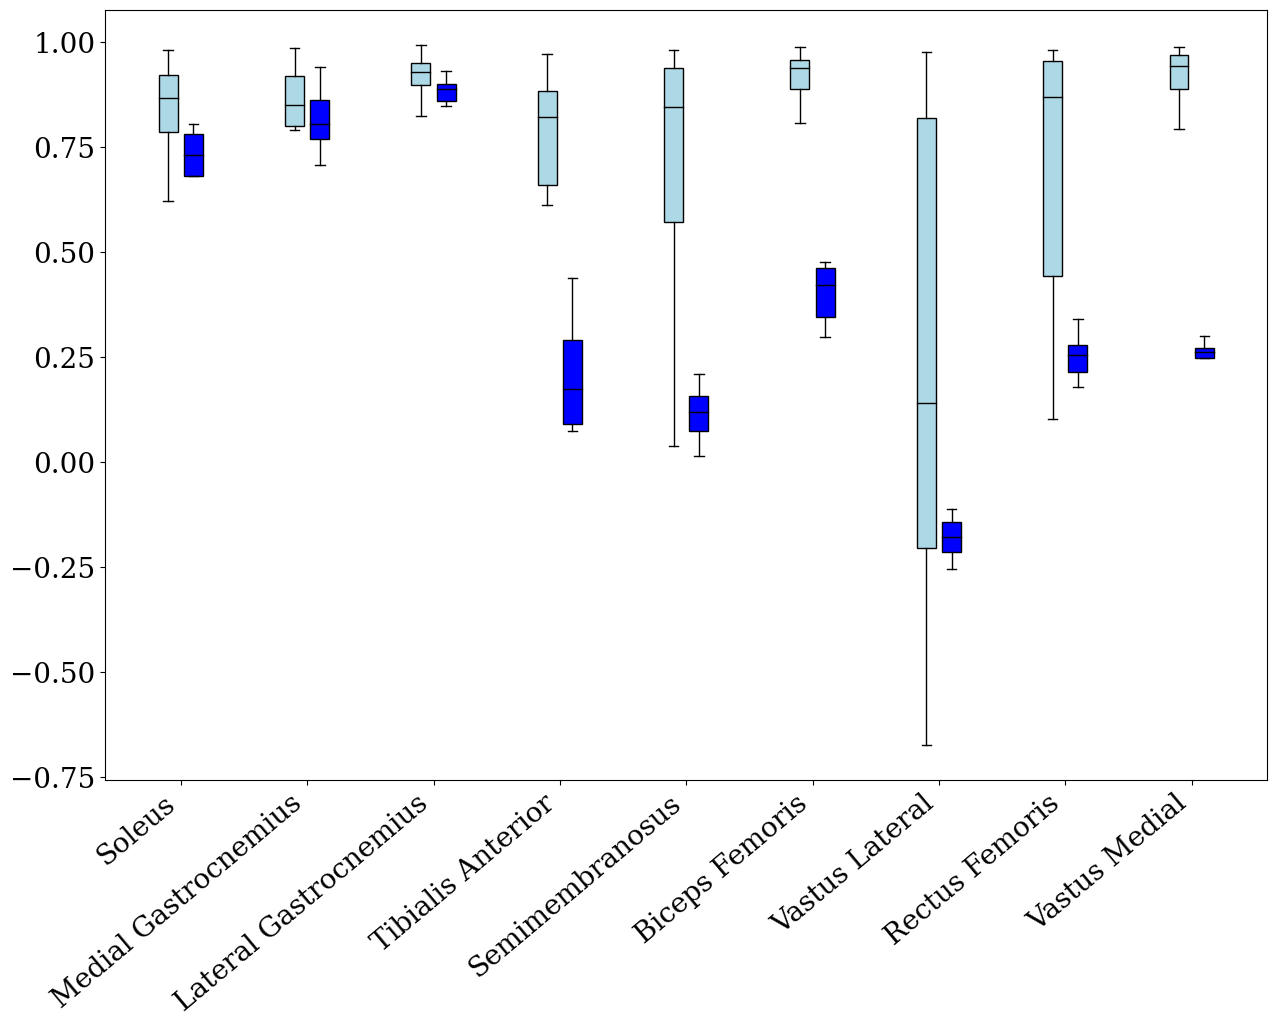

In [15]:
# Boxplot
plt.figure(figsize=(15, 10))

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['font.size'] = 20

colors = ['lightblue', 'blue', 'orange', 'red']

b1 = plt.boxplot(hh_correlation, positions=np.array(range(1, 10)) - 0.1, widths=0.15, patch_artist=True, medianprops=dict(color='black'), showfliers=False, boxprops=dict(facecolor=colors[0]))
b2 = plt.boxplot(hs_correlation, positions=np.array(range(1, 10)) + 0.1, widths=0.15, patch_artist=True, medianprops=dict(color='black'), showfliers=False, boxprops=dict(facecolor=colors[1]))
plt.xticks(range(1, 10), muscle_map.keys(), rotation=40, ha='right')
plt.show()

We also calculate and visualize the overall correlation averages per subject:

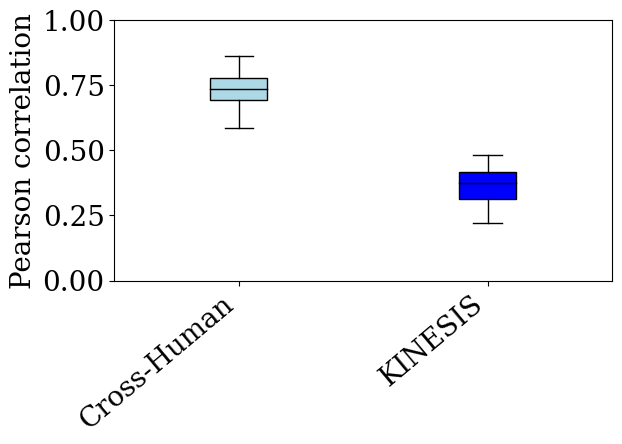

In [16]:
# Per-subject correlation (averaged over muscles)
hh_correlation_mean = np.mean(hh_correlation, axis=1)
hs_correlation_mean = np.mean(hs_correlation, axis=1)

b1 = plt.boxplot(hh_correlation_mean, positions=[0], widths=0.23, patch_artist=True, medianprops=dict(color='black'), showfliers=False, boxprops=dict(facecolor=colors[0]))
b2 = plt.boxplot(hs_correlation_mean, positions=[1], widths=0.23, patch_artist=True, medianprops=dict(color='black'), showfliers=False, boxprops=dict(facecolor=colors[1]))

plt.xticks([0, 1], ['Cross-Human', 'KINESIS'], rotation=40, ha='right')
plt.ylabel("Pearson correlation")
plt.ylim(0, 1)
plt.tight_layout(pad=1.0)

plt.show()

### Timing Analysis

Finally, we analyze whether the gait cycle timing in our simulation aligns optimally with the human data:

[]

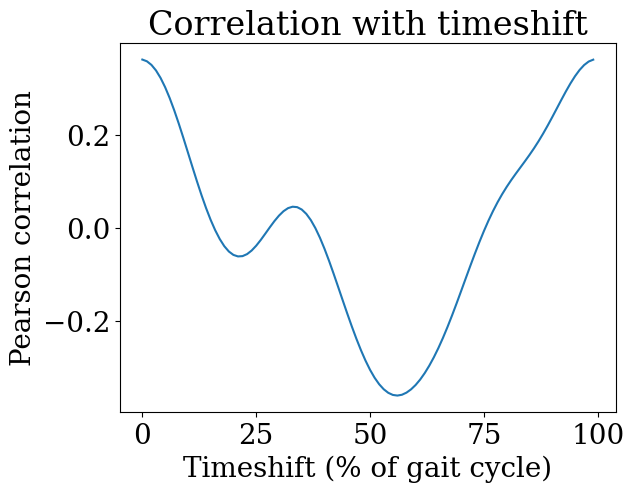

In [17]:
# test whether we have timed the gait cycle well

# define a timeshift for the simulated data
timeshifts = np.arange(0, 100, 1)
# calculate the correlation for each timeshift
corrs = np.zeros((len(timeshifts)))
for i, timeshift in enumerate(timeshifts):
    # shift the simulated data
    shifted_correlation = np.zeros((9, 9))
    for muscle_id in range(9):
        for sb in range(4, 13):
            shifted_correlation[sb - 4, muscle_id] = np.corrcoef(human_emg[sb][:, muscle_id + 1], 
                                                                np.roll(simulated_control[:, muscle_id], timeshift))[0, 1]
    # average
    corrs[i] = np.mean(shifted_correlation)
plt.plot(timeshifts, corrs)
plt.xlabel("Timeshift (% of gait cycle)")
plt.ylabel("Pearson correlation")
plt.title("Correlation with timeshift")
plt.plot()

We see that the timing between our definition of the gait cycle and the human data is aligned.